In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import glob

The previous notebooks reconstructed HRDPS for a particular time (12 UTC) from daily CANRCM data. This notebook reconstructs each time, and then combines them to fully predict the 3-hourly winds from daily CANRCM. 

## Importing Training Data

In [27]:
##2007 HRDPS import

files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m??d??.nc')
##list of data files, febrary 2007 - each file covers one day, with hourly data
##the grid is 266 by 256 points, with resolution 2.5km
##relevant data in this file is u_wind and v_wind data
files.sort()
print(len(files))

## 3-hour averaged matrix

hr07_u = np.zeros( (8*len(files), 266, 256)) 
hr07_v = np.zeros( (8*len(files), 266, 256)) 

for i in range(len(files)):
    dayX = xr.open_dataset(files[i])
    avg_u = np.array( dayX['u_wind'] ).reshape(8, 3, 266, 256).mean(axis = 1)
    avg_v = np.array( dayX['v_wind'] ).reshape(8, 3, 266, 256).mean(axis = 1)
    hr07_u[8*i:8*i + 8, : , : ] = avg_u ##adding 3-hour average to new data array
    hr07_v[8*i:8*i + 8, : , : ] = avg_v

del avg_u
del avg_v
del dayX

363


In [28]:
##CANRCM 2007 import
p1 = '/home/arandhawa/canrcm_uas_2007.nc'
p2 = '/home/arandhawa/canrcm_vas_2007.nc'

d1 = xr.open_dataset(p1)
d2 = xr.open_dataset(p2)
##daily averages
can07_u = np.array( d1['uas'][16:,140:165,60:85] ).reshape(-1, 8, 25, 25).mean(axis = 1) ##daily averages
can07_v = np.array( d2['vas'][16:,140:165,60:85] ).reshape(-1, 8, 25, 25).mean(axis = 1)

print(can07_u.shape)

(363, 25, 25)


## Comparing Daily data to Averaged Data

In [29]:
p3 = '/home/arandhawa/canrcm_uas_2006-2009_daily.nc'

d3 = xr.open_dataset(p3)

can_d = np.array( d3['uas'][367:2*365,140:165,60:85] ) ##splicing to cover same timeframe as 2007 data

print(can_d.shape)


(363, 25, 25)


In [30]:
diff = can_d - can07_u
print(np.max(diff))

0.0014998913


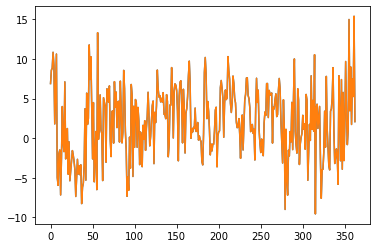

In [32]:
plt.plot(can_d[:,10, 10])
plt.plot(can07_u[:, 10, 10])

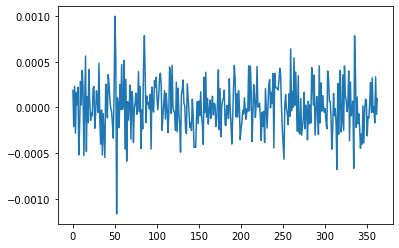

In [34]:
plt.plot(diff[:, 10, 10])

## PCA Functions

In [35]:
##transforms and concatenates two data sets
def transform2(data1, data2):
    A_mat = transform(data1)
    B_mat = transform(data2)
    return np.concatenate((A_mat, B_mat), axis=0) 

In [36]:
##inverse function of transform2 - splits data matrix and returns two data sets
def reverse2(matrix, orig_shape):
    split4 = int( matrix.shape[0]/2 )
    u_data = reverse(matrix[:split4,:], orig_shape) ##reconstructing u_winds from n PCs
    v_data = reverse(matrix[split4:,:], orig_shape) ##reconstructing v_winds from n PCs
    return (u_data, v_data)

In [37]:
##performs PCA analysis using sklearn.pca
def doPCA(comp, matrix):
    pca = PCA(n_components = comp) ##adjust the number of principle conponents to be calculated
    PCs = pca.fit_transform(matrix)
    eigvecs = pca.components_
    mean = pca.mean_
    return (PCs, eigvecs, mean)

In [38]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr) ##converting to numpy array
    arr = arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2]) ##reshaping from size (a, b, c) to (a, b*c)
    arr = arr.transpose()
    return arr

def reverse(mat, orig_shape):
    arr = np.copy(mat)
    arr = arr.transpose()
    arr = arr.reshape(-1, orig_shape[1], orig_shape[2]) ##reshaping back to original array shape
    return arr

In [39]:
##graphing percentage of original data represented by the first n principle conponents
def graph_variance(matrix, n):
    pcaG = PCA(n_components = n) ##Number of principle conponents to show
    PCsG = pcaG.fit_transform(matrix)
    plt.plot(np.cumsum(pcaG.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()
    del pcaG
    del PCsG

In [40]:
##can be used to visualize principle conponents for u/v winds
def graph_nPCs(PCs, eigvecs, n, orig_shape):
    fig, ax = plt.subplots(n, 3, figsize=(10, 3*n))
    
    ax[0, 0].set_title("u-conponent")
    ax[0, 1].set_title("v-component")
    ax[0, 2].set_title("time-loadings")
    
    for i in range(n):
        mode_u, mode_v = get_mode(PCs, i, orig_shape)
        colors = ax[i, 0].pcolormesh(mode_u, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,0])
        colors = ax[i, 1].pcolormesh(mode_v, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,1])
        ax[i, 2].plot(eigvecs[i])

    plt.tight_layout()
    plt.show()

##converts PCs (column vectors) to 2d conpoents for u and v wind
def get_mode(PCs, n, orig_shape): 
    split = int(PCs.shape[0]/2)
    mode_u = PCs[:split, n].reshape(orig_shape[1], orig_shape[2])
    mode_v = PCs[split:, n].reshape(orig_shape[1], orig_shape[2])
    return (mode_u, mode_v)



## PCAs on Training Data

In [41]:
can07_mat = transform2(can07_u, can07_v)
can07_PCs, can07_eigs, can07_mean = doPCA(100, can07_mat)
##combined mean and eigenvectors
can07_me = np.concatenate((can07_mean.reshape(1, -1), can07_eigs))

In [42]:
##function to do PCA on slice of HRDPS data
def doPCA_slice(t):
    hr07_mat = transform2(hr07_u[t::8], hr07_v[t::8])
    hr07_PCs, hr07_eigs, hr07_mean = doPCA(100, hr07_mat)
    hr07_me = np.concatenate((hr07_mean.reshape(1, -1), hr07_eigs))
    return (hr07_PCs, hr07_me)

In [43]:
del can07_u
del can07_v

## Multiple Linear Regression Functions

In [44]:
##functions that use multiple linear regression to fit eigenvectors
##takes CANRCM eigenvectors (x1, x2, x3, x4...) and HRDPS eigenvectors (y1, y2, y3...)
##For each y from 0:result_size, approximates yn = a0 + a1*x1 + a2*x2 + a3*x3 ... using num_vec x's
##getCoefs returns (coeficients, intercept)
##fit_modes returns each approximation and the R^2 value of each fit as (results, scores)

def getCoefs(vectors, num_vec, data, num_modes, type = 'LS'):  
    
    X = vectors[0:num_vec,:].T
    coefs = np.zeros((num_modes, X.shape[1]))
    intercept = np.zeros(num_modes)
    
    if type == 'LS':
        for i in range(num_modes):
            y = data[i,:]
            reg = LinearRegression().fit(X, y)
            coefs[i] = reg.coef_[0:num_vec]
            intercept[i] =  reg.intercept_
    elif type == 'MAE':
        for i in range(num_modes):
            y = data[i,:]
            reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
            coefs[i] = reg.coef_[0:num_vec]
            intercept[i] =  reg.intercept_
    
    return (coefs, intercept)


def fit_modes(vectors, num_vec, data, result_size, type = 'LS'):  
    
    X = vectors[0:num_vec,:].T
    result = np.zeros((result_size, X.shape[0]))
    scores = np.zeros(result_size)
    
    if type == 'LS':
        for i in range(result_size):
            y = data[i,:]
            reg = LinearRegression().fit(X, y)
            result[i] = reg.predict(X)
            scores[i] = reg.score(X, y)
            
    elif type == 'MAE':
        for i in range(result_size):
            y = data[i,:]
            reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
            result[i] = reg.predict(X)
            scores[i] = reg.score(X, y)
    
    return (result, scores)


In [45]:
##returns the ratio of the average energy between two sets of eigenvectors (element-wise)
##"energy" is defined as value^2 - two sets of eigenvectors with the same "energy" would
##recreate data with approximately the same kinetic energy (v^2)

def getEnergyCoefs(eigs, old_eigs):
    coefs = np.sqrt( (old_eigs[0:eigs.shape[0]]**2).mean(axis = 1)/(eigs**2).mean(axis = 1))
    return coefs

## Importing data for downscaling

In [46]:
##supposed to be 2008 canrcm data
p1 = '/home/arandhawa/canrcm_uas_2008.nc'
p2 = '/home/arandhawa/canrcm_vas_2008.nc'

d1 = xr.open_dataset(p1)
d2 = xr.open_dataset(p2)

In [47]:
##duplicating feb 28 twice to account for leap year (feb 29th is missing in CANRCM)
can08_u = np.concatenate((d1['uas'][:472,140:165,60:85], d1['uas'][464:472,140:165,60:85], d1['uas'][472:,140:165,60:85] ))
can08_v = np.concatenate((d2['vas'][:472,140:165,60:85], d2['vas'][464:472,140:165,60:85], d2['vas'][472:,140:165,60:85]))

In [48]:
can08_u = can08_u.reshape(-1, 8, 25, 25).mean(axis = 1) ##daily averages
can08_v = can08_v.reshape(-1, 8, 25, 25).mean(axis = 1)

In [49]:
##not duplicating feb 28 twice - for other years of data
##can08_u = d1['uas'][16:,140:165,60:85]
##can08_v = d2['vas'][16:,140:165,60:85]

In [50]:
can08_mat = transform2(can08_u, can08_v)

##calculating average of rows
mean_2008 = can08_mat.mean(axis = 0)

## Projection Function

In [51]:
##scalar projection of u onto v - with extra 1/norm factor (for math reasons)
##projectData projects the data onto each principle conponent, at each time
##output is a set of eigenvectors

def project(u, v):  
    v_norm = np.sqrt(np.sum(v**2))    
    return np.dot(u, v)/v_norm**2

def projectData(data_mat, new_PCs, n):
    time = data_mat.shape[1]
    proj = np.empty((n, time))

    for j in range(n):
        for i in range(time):
            proj[j, i] = project(data_mat[:,i], new_PCs[:,j])
            
    return proj

## Overall Function

In [52]:
def reconstruct(downscale_mat, mean, can_PCs, can_me, hr_PCs, hr_me, n, r, method = 'LS', EB = 'false'):

    coefs = getCoefs(can_me, n + 1, hr_me, r + 1, type = method)
    proj = np.concatenate((mean.reshape(1, -1), projectData(downscale_mat - mean, can_PCs, n)), axis = 0)
    pred_eigs = np.matmul(coefs[0], proj) + coefs[1].reshape(-1, 1)  ##multiple linear regression output
    if (EB == 'true'):
        energyCoefs = getEnergyCoefs( fit_modes(can_me, n + 1, hr_me, r + 1, type = method)[0], hr_me)
        energyCoefs = energyCoefs.reshape(-1, 1)
        pred_eigs = pred_eigs*energyCoefs ##energy balancing
    if (EB == 'function'):
        energyCoefs = getEnergyCoefs( fit_modes(can_me, n + 1, hr_me, r + 1, type = method)[0] , hr_me)
        def f(x):
            return np.exp(-x/50)
        for x in range(r + 1):
            energyCoefs = (energyCoefs - 1)*f(x) + 1
        energyCoefs = energyCoefs.reshape(-1, 1)
        pred_eigs = pred_eigs*energyCoefs ##energy balancing
    
    recon = np.matmul(hr_PCs[:,0:r], pred_eigs[1:r+1]) + pred_eigs[0]
    u_data_rec, v_data_rec = reverse2(recon, (-1, 266, 256))
    if not isinstance(EB, str): 
        u_data_rec *= EB
        v_data_rec *= EB
        ##assuming EB is a numerical type, data is multiplied up by EB
    
    return (u_data_rec, v_data_rec)

## Reconstruction

In [53]:
##2008 HRDPS import - for comparison to predictions

files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2008m??d??.nc')
##list of data files, febrary 2007 - each file covers one day, with hourly data
##the grid is 266 by 256 points, with resolution 2.5km
##relevant data in this file is u_wind and v_wind data
files.sort()
print(len(files))

## 3-hour averaged matrix

hr08_u = np.empty( (8*len(files), 266, 256)) 
hr08_v = np.empty( (8*len(files), 266, 256)) 

for i in range(len(files)):
    dayX = xr.open_dataset(files[i])
    avg_u = np.array( dayX['u_wind'] ).reshape(8, 3, 266, 256).mean(axis = 1)
    avg_v = np.array( dayX['v_wind'] ).reshape(8, 3, 266, 256).mean(axis = 1)
    hr08_u[8*i:8*i + 8, : , : ] = avg_u ##adding 3-hour average to new data array
    hr08_v[8*i:8*i + 8, : , : ] = avg_v

del avg_u
del avg_v
del dayX

366


In [54]:
HB_u = hr08_u[:,142,139]
SS_u = hr08_u[:,174,107]
SH_u = hr08_u[:,129,149]

HB_v = hr08_v[:,142,139]
SS_v = hr08_v[:,174,107]
SH_v = hr08_v[:,129,149]

del hr08_u
del hr08_v

print(HB_u.shape)

(2928,)


In [55]:
hr07_u.shape

(2904, 266, 256)

In [56]:
u_data_rec = np.empty((366*8, 266, 256))
v_data_rec = np.empty((366*8, 266, 256))
for i in range(8):
    hr07_PCs, hr07_me = doPCA_slice(i)
    u_data_rec[i::8], v_data_rec[i::8] = reconstruct(can08_mat, mean_2008, can07_PCs, can07_me, hr07_PCs, hr07_me, 65, 65, method = 'LS')

In [57]:
u_data_rec *= 1.25
v_data_rec *= 1.25

In [58]:
u_data_rec.shape

(2928, 266, 256)

## Analysis

HB_u RMSE: 4.488114215565411 SS_u RMSE: 3.462127156727475 SH_u RMSE: 3.9090785980223104
HB_v RMSE: 2.5335054065592657 SS_v RMSE: 3.679597410497574 SH_v RMSE: 2.8706282619183483
HB RMSE: 3.3222270606558197 SS RMSE: 7.640430350961987 SH RMSE: 2.9033854124699827
Average RMSE u: 3.953106656771732 Average RMSE v: 3.027910359658396
Average RMSE u and v winds: 3.490508508215064


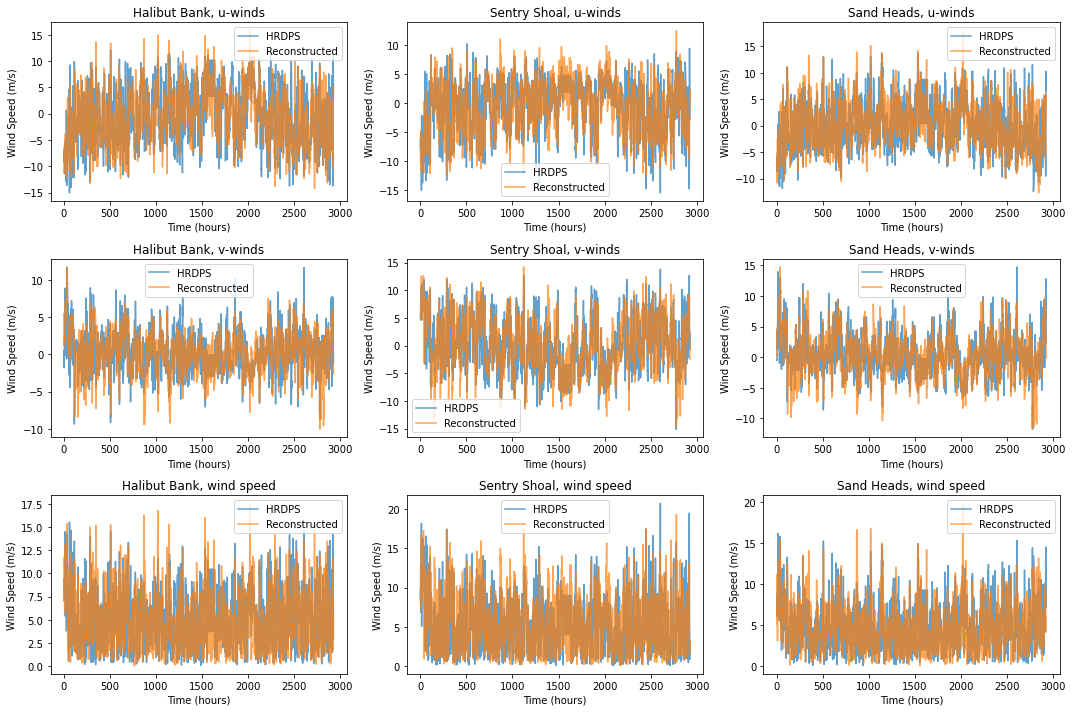

In [59]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
alpha_val = 0.7

ax[0, 0].plot(HB_u, label = "HRDPS", alpha = alpha_val)
ax[0, 0].plot(u_data_rec[:,142,139], label = "Reconstructed", alpha = alpha_val)
ax[0, 0].set_title("Halibut Bank, u-winds")
ax[0, 0].set_xlabel("Time (hours)")
ax[0, 0].set_ylabel("Wind Speed (m/s)")
ax[0, 0].legend()

ax[0, 1].plot(SS_u, label = "HRDPS", alpha = alpha_val)
ax[0, 1].plot(u_data_rec[:,174,107], label = "Reconstructed", alpha = alpha_val)
ax[0, 1].set_title("Sentry Shoal, u-winds")
ax[0, 1].set_xlabel("Time (hours)")
ax[0, 1].set_ylabel("Wind Speed (m/s)")
ax[0, 1].legend()

ax[0, 2].plot(SH_u, label = "HRDPS", alpha = alpha_val)
ax[0, 2].plot(u_data_rec[:,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[0, 2].set_title("Sand Heads, u-winds")
ax[0, 2].set_xlabel("Time (hours)")
ax[0, 2].set_ylabel("Wind Speed (m/s)")
ax[0, 2].legend()
print("HB_u RMSE:", np.sqrt( mean_squared_error(HB_u, u_data_rec[:,142,139])), 
                            "SS_u RMSE:", np.sqrt( mean_squared_error(SS_u, u_data_rec[:,174,107])), 
                                                  "SH_u RMSE:", np.sqrt( mean_squared_error(SH_u, u_data_rec[:,129, 149])))

ax[1, 0].plot(HB_v, label = "HRDPS", alpha = alpha_val)
ax[1, 0].plot(v_data_rec[:,142,139], label = "Reconstructed", alpha = alpha_val)
ax[1, 0].set_title("Halibut Bank, v-winds")
ax[1, 0].set_xlabel("Time (hours)")
ax[1, 0].set_ylabel("Wind Speed (m/s)")
ax[1, 0].legend()

ax[1, 1].plot(SS_v, label = "HRDPS", alpha = alpha_val)
ax[1, 1].plot(v_data_rec[:,174,107], label = "Reconstructed", alpha = alpha_val)
ax[1, 1].set_title("Sentry Shoal, v-winds")
ax[1, 1].set_xlabel("Time (hours)")
ax[1, 1].set_ylabel("Wind Speed (m/s)")
ax[1, 1].legend()

ax[1, 2].plot(SH_v, label = "HRDPS", alpha = alpha_val)
ax[1, 2].plot(v_data_rec[:,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[1, 2].set_title("Sand Heads, v-winds")
ax[1, 2].set_xlabel("Time (hours)")
ax[1, 2].set_ylabel("Wind Speed (m/s)")
ax[1, 2].legend()

print("HB_v RMSE:", np.sqrt( mean_squared_error(HB_v, v_data_rec[:,142,139])), 
                            "SS_v RMSE:", np.sqrt( mean_squared_error(SS_v, v_data_rec[:,174,107])), 
                                                  "SH_v RMSE:", np.sqrt( mean_squared_error(SH_v, v_data_rec[:,129, 149])))

ax[2,0].plot(np.sqrt(HB_u**2 + HB_v**2), label = "HRDPS", alpha = alpha_val)
ax[2,0].plot(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), label = "Reconstructed", alpha = alpha_val)
ax[2,0].set_xlabel("Time (hours)")
ax[2,0].set_title("Halibut Bank, wind speed")
ax[2,0].set_ylabel("Wind Speed (m/s)")
ax[2,0].legend()

ax[2,1].plot(np.sqrt(SS_u**2 + SS_v**2), label = "HRDPS", alpha = alpha_val)
ax[2,1].plot(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), label = "Reconstructed", alpha = alpha_val)
ax[2,1].set_xlabel("Time (hours)")
ax[2,1].set_title("Sentry Shoal, wind speed")
ax[2,1].set_ylabel("Wind Speed (m/s)")
ax[2,1].legend()

ax[2,2].plot(np.sqrt(SH_u**2 + SH_v**2) , label = "HRDPS", alpha = alpha_val)
ax[2,2].plot(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , label = "Reconstructed", alpha = alpha_val)
ax[2,2].set_xlabel("Time (hours)")
ax[2,2].set_title("Sand Heads, wind speed")
ax[2,2].set_ylabel("Wind Speed (m/s)")
ax[2,2].legend()

print("HB RMSE:", np.sqrt( mean_squared_error(np.sqrt(HB_u**2 + HB_v**2), np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2))), 
                            "SS RMSE:", np.sqrt( mean_squared_error(np.sqrt(SS_u**2 + SS_v**2), v_data_rec[:,174,107])), 
                                                  "SH RMSE:", np.sqrt( mean_squared_error(np.sqrt(SH_u**2 + SH_v**2), np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2))))
avg_rmse_u = (np.sqrt( mean_squared_error(HB_u, u_data_rec[:,142,139])) + np.sqrt( mean_squared_error(SS_u, u_data_rec[:,174,107])) + np.sqrt( mean_squared_error(SH_u, u_data_rec[:,129, 149])))/3
avg_rmse_v = (np.sqrt( mean_squared_error(HB_v, v_data_rec[:,142,139])) + np.sqrt( mean_squared_error(SS_v, v_data_rec[:,174,107])) + np.sqrt( mean_squared_error(SH_v, v_data_rec[:,129, 149])))/3

avg_rmse = (avg_rmse_u + avg_rmse_v)/2
print("Average RMSE u:", avg_rmse_u, "Average RMSE v:", avg_rmse_v)
print("Average RMSE u and v winds:", avg_rmse)
plt.tight_layout()

Average RMSE u: 3.829748569329205 Average RMSE v: 3.810170799822379
Average RMSE u and v winds: 3.819959684575792


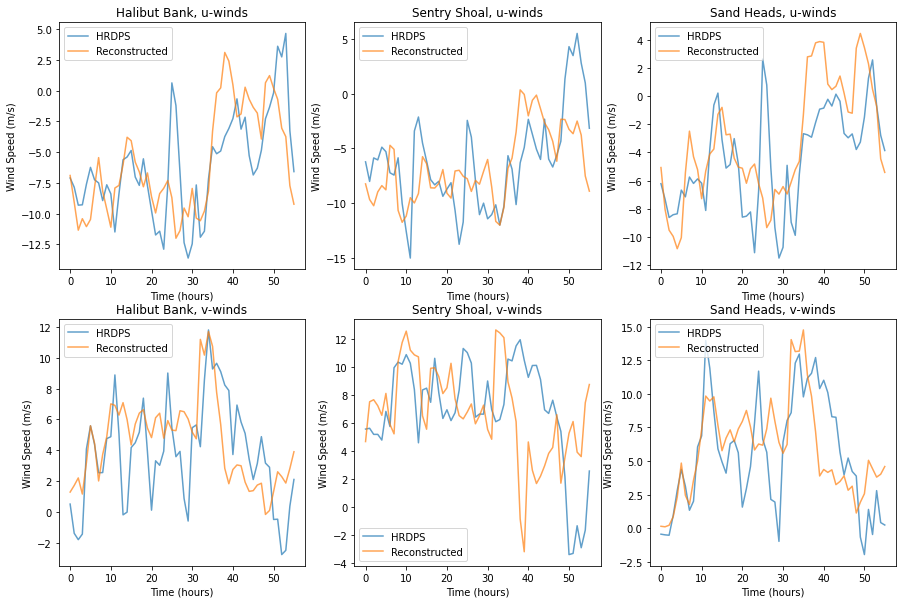

In [69]:
##plotting 1 week of data
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
alpha_val = 0.7

ax[0, 0].plot(HB_u[:56], label = "HRDPS", alpha = alpha_val)
ax[0, 0].plot(u_data_rec[:56,142,139], label = "Reconstructed", alpha = alpha_val)
ax[0, 0].set_title("Halibut Bank, u-winds")
ax[0, 0].set_xlabel("Time (hours)")
ax[0, 0].set_ylabel("Wind Speed (m/s)")
ax[0, 0].legend()

ax[0, 1].plot(SS_u[:56], label = "HRDPS", alpha = alpha_val)
ax[0, 1].plot(u_data_rec[:56,174,107], label = "Reconstructed", alpha = alpha_val)
ax[0, 1].set_title("Sentry Shoal, u-winds")
ax[0, 1].set_xlabel("Time (hours)")
ax[0, 1].set_ylabel("Wind Speed (m/s)")
ax[0, 1].legend()

ax[0, 2].plot(SH_u[:56], label = "HRDPS", alpha = alpha_val)
ax[0, 2].plot(u_data_rec[:56,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[0, 2].set_title("Sand Heads, u-winds")
ax[0, 2].set_xlabel("Time (hours)")
ax[0, 2].set_ylabel("Wind Speed (m/s)")
ax[0, 2].legend()

ax[1, 0].plot(HB_v[:56], label = "HRDPS", alpha = alpha_val)
ax[1, 0].plot(v_data_rec[:56,142,139], label = "Reconstructed", alpha = alpha_val)
ax[1, 0].set_title("Halibut Bank, v-winds")
ax[1, 0].set_xlabel("Time (hours)")
ax[1, 0].set_ylabel("Wind Speed (m/s)")
ax[1, 0].legend()

ax[1, 1].plot(SS_v[:56], label = "HRDPS", alpha = alpha_val)
ax[1, 1].plot(v_data_rec[:56,174,107], label = "Reconstructed", alpha = alpha_val)
ax[1, 1].set_title("Sentry Shoal, v-winds")
ax[1, 1].set_xlabel("Time (hours)")
ax[1, 1].set_ylabel("Wind Speed (m/s)")
ax[1, 1].legend()

ax[1, 2].plot(SH_v[:56], label = "HRDPS", alpha = alpha_val)
ax[1, 2].plot(v_data_rec[:56,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[1, 2].set_title("Sand Heads, v-winds")
ax[1, 2].set_xlabel("Time (hours)")
ax[1, 2].set_ylabel("Wind Speed (m/s)")
ax[1, 2].legend()

avg_rmse_u = (np.sqrt( mean_squared_error(HB_u[:56], u_data_rec[:56,142,139])) + np.sqrt( mean_squared_error(SS_u[:56], u_data_rec[:56,174,107])) + np.sqrt( mean_squared_error(SH_u[:56], u_data_rec[:56,129, 149])))/3
avg_rmse_v = (np.sqrt( mean_squared_error(HB_v[:56], v_data_rec[:56,142,139])) + np.sqrt( mean_squared_error(SS_v[:56], v_data_rec[:56,174,107])) + np.sqrt( mean_squared_error(SH_v[:56], v_data_rec[:56,129, 149])))/3

avg_rmse = (avg_rmse_u + avg_rmse_v)/2
print("Average RMSE u:", avg_rmse_u, "Average RMSE v:", avg_rmse_v)
print("Average RMSE u and v winds:", avg_rmse)

Total energy (sum of v^2)
HB HRDPS: 111692.66759283163 HB recon: 101908.00609543092
SS HRDPS: 122378.94221771439 HB recon: 126923.94413522483
SH HRDPS: 92461.35785913625 HB recon: 90943.56976662026
Energy ratio: 1.0105106867162754


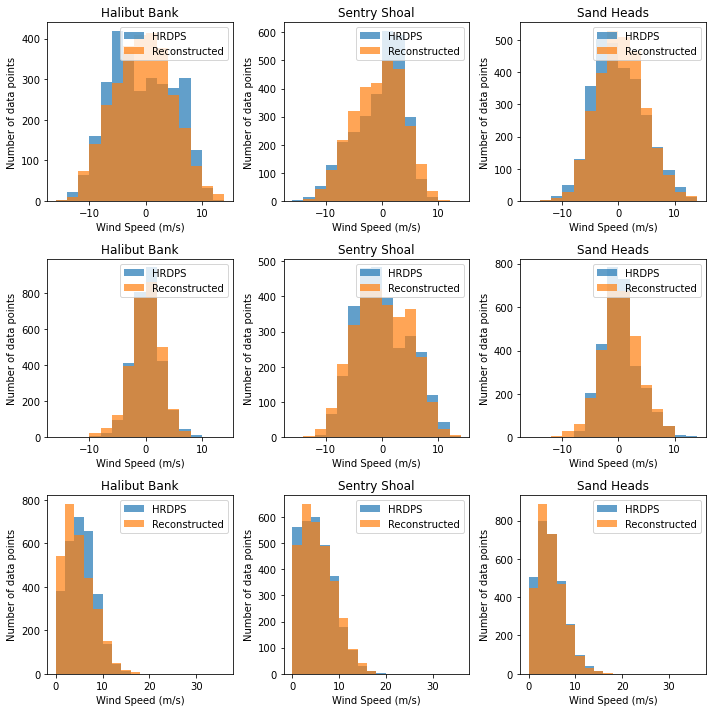

In [60]:
nums = np.arange(0, 37, 2)
nums2 = np.arange(-16, 16, 2)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

ax[0, 0].set_title("Halibut Bank")
ax[0, 0].hist(HB_u, bins = nums2, label = "HRDPS", alpha = 0.7)
ax[0, 0].hist(u_data_rec[:,142,139], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[0, 0].set_xlabel("Wind Speed (m/s)")
ax[0, 0].set_ylabel("Number of data points")
ax[0, 0].legend()

ax[0, 1].set_title("Sentry Shoal")
ax[0, 1].hist(SS_u, bins = nums2, label = "HRDPS", alpha = 0.7)
ax[0, 1].hist(u_data_rec[:,174,107], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[0, 1].set_xlabel("Wind Speed (m/s)")
ax[0, 1].set_ylabel("Number of data points")
ax[0, 1].legend()

ax[0, 2].set_title("Sand Heads")
ax[0, 2].hist(SH_u, bins = nums2,  label = "HRDPS", alpha = 0.7)
ax[0, 2].hist(u_data_rec[:,129,149], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[0, 2].set_xlabel("Wind Speed (m/s)")
ax[0, 2].set_ylabel("Number of data points")
ax[0, 2].legend()

ax[1, 0].set_title("Halibut Bank")
ax[1, 0].hist(HB_v, bins = nums2, label = "HRDPS", alpha = 0.7)
ax[1, 0].hist(v_data_rec[:,142,139], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[1, 0].set_xlabel("Wind Speed (m/s)")
ax[1, 0].set_ylabel("Number of data points")
ax[1, 0].legend()

ax[1, 1].set_title("Sentry Shoal")
ax[1, 1].hist(SS_v, bins = nums2, label = "HRDPS", alpha = 0.7)
ax[1, 1].hist(v_data_rec[:,174,107], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[1, 1].set_xlabel("Wind Speed (m/s)")
ax[1, 1].set_ylabel("Number of data points")
ax[1, 1].legend()

ax[1, 2].set_title("Sand Heads")
ax[1, 2].hist(SH_v, bins = nums2,  label = "HRDPS", alpha = 0.7)
ax[1, 2].hist(v_data_rec[:,129,149], bins = nums2, label = "Reconstructed", alpha = 0.7)
ax[1, 2].set_xlabel("Wind Speed (m/s)")
ax[1, 2].set_ylabel("Number of data points")
ax[1, 2].legend()

ax[2, 0].set_title("Halibut Bank")
ax[2, 0].hist(np.sqrt(HB_u**2 + HB_v**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[2, 0].hist(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[2, 0].set_xlabel("Wind Speed (m/s)")
ax[2, 0].set_ylabel("Number of data points")
ax[2, 0].legend()

ax[2, 1].set_title("Sentry Shoal")
ax[2, 1].hist(np.sqrt(SS_u**2 + SS_v**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[2, 1].hist(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[2, 1].set_xlabel("Wind Speed (m/s)")
ax[2, 1].set_ylabel("Number of data points")
ax[2, 1].legend()

ax[2, 2].set_title("Sand Heads")
ax[2, 2].hist(np.sqrt(SH_u**2 + SH_v**2) , bins = nums,  label = "HRDPS", alpha = 0.7)
ax[2, 2].hist(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , bins = nums, label = "Reconstructed", alpha = 0.7)
ax[2, 2].set_xlabel("Wind Speed (m/s)")
ax[2, 2].set_ylabel("Number of data points")
ax[2, 2].legend()

plt.tight_layout()
print("Total energy (sum of v^2)")
print("HB HRDPS:", np.sum(HB_u**2 + HB_v**2), "HB recon:", np.sum(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2))
print("SS HRDPS:", np.sum(SS_u**2 + SS_v**2), "HB recon:", np.sum(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2))
print("SH HRDPS:", np.sum(SH_u**2 + SH_v**2), "HB recon:", np.sum(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2))
hr_energy_avg = np.sum(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2) + np.sum(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2)
hr_energy_avg += np.sum(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2)
hr_energy_avg /= 3
recon_energy_avg = (np.sum(HB_u**2 + HB_v**2) + np.sum(SS_u**2 + SS_v**2) + np.sum(SH_u**2 + SH_v**2))/3

ratio = np.sqrt(recon_energy_avg/hr_energy_avg)
print("Energy ratio:", ratio)

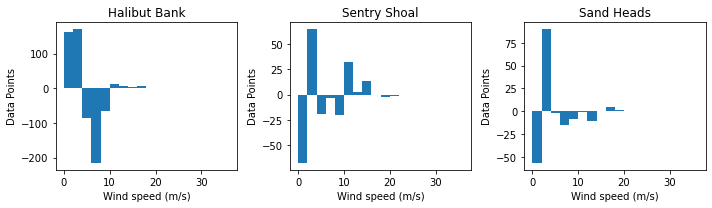

In [61]:
a1 = np.histogram(np.sqrt(HB_u**2 + HB_v**2), bins = nums)
b1 = np.histogram(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), bins = nums)

a2 = np.histogram(np.sqrt(SS_u**2 + SS_v**2), bins = nums)
b2 = np.histogram(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), bins = nums)

a3 = np.histogram(np.sqrt(SH_u**2 + SH_v**2), bins = nums)
b3 = np.histogram(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , bins = nums)

# calc middle of bin and width of bin
axes = [(a1[1][x]+a1[1][x+1])/2 for x in range(len(a1[1])-1)] 
w = a1[1][1]
##plot differences
fig, ax = plt.subplots(1, 3, figsize = (10, 3))

ax[0].bar(axes, b1[0] - a1[0], width=w, label="Reconstruct - HRDPS 2008")
ax[0].set_title("Halibut Bank")
ax[1].bar(axes, b2[0] - a2[0], width=w, label="Reconstruct - HRDPS 2008")
ax[1].set_title("Sentry Shoal")
ax[2].bar(axes, b3[0] - a3[0], width=w, label="Reconstruct - HRDPS 2008")
ax[2].set_title("Sand Heads")

for i in range(3):
    ax[i].set_xlabel("Wind speed (m/s)")
    ax[i].set_ylabel("Data Points")
plt.tight_layout()

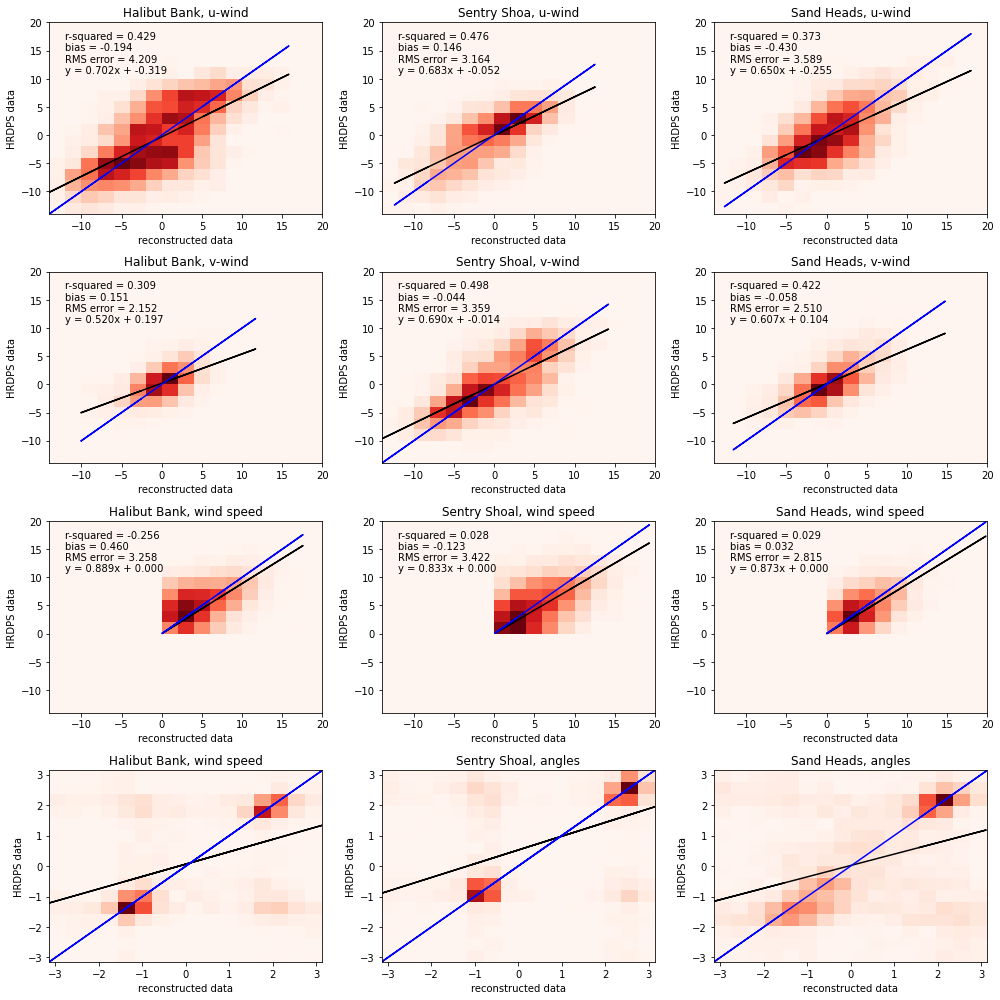

In [62]:
metrics = np.zeros((3, 3, 3))

def helper(x, y, ax, i, j):
    
    if i == 2:
        myBool = False
    else:
        myBool = True
    
    reg = LinearRegression(fit_intercept = myBool).fit(x.reshape(-1, 1), y)
    a = reg.coef_[0]
    b = reg.intercept_
    y_pred = a*x + b
    
    bias = np.mean( y - x )
    r_squared = reg.score(x.reshape(-1, 1), y)
    rmse = np.sqrt( mean_squared_error(y, y_pred) )
    
    global metrics
    if i != 3:
        metrics[i, j, 0] = r_squared
        metrics[i, j, 1] = bias
        metrics[i, j, 2] = rmse
    
    if i != 3:
        ax[i,j].hist2d(x, y, bins = (17, 17), range = [[-14, 20], [-14, 20]], cmap=plt.cm.Reds)
        ax[i,j].plot(x, a*x+b, color = 'black')
        ax[i,j].plot(x, x, color = 'blue')
        ax[i,j].annotate("r-squared = {:.3f}".format(r_squared), (-12, 17))
        ax[i,j].annotate("bias = {:.3f}".format(bias), (-12, 15))
        ax[i,j].annotate("RMS error = {:.3f}".format(rmse), (-12, 13))
        ax[i,j].annotate("y = {:.3f}x + {:.3f}".format(a, b), (-12, 11))
        ax[i,j].set_ylabel("HRDPS data")
        ax[i,j].set_xlabel("reconstructed data")
        ax[i,j].set_ylim(-14, 20)
        ax[i,j].set_xlim(-14, 20)
    else:
        ax[i,j].hist2d(x, y, bins = (16, 16), range = [[-np.pi, np.pi], [-np.pi, np.pi]], cmap=plt.cm.Reds)
        ax[i,j].plot(x, a*x+b, color = 'black')
        ax[i,j].plot(x, x, color = 'blue')
        ax[i,j].set_ylabel("HRDPS data")
        ax[i,j].set_xlabel("reconstructed data")
        ax[i,j].set_ylim(-np.pi, np.pi)
        ax[i,j].set_xlim(-np.pi, np.pi)

    return (a, b)
    ## plt.colorbar(im,ax=ax[i,j]) 
    ##https://stackoverflow.com/questions/23876588/matplotlib-colorbar-in-each-subplot

a = np.empty((4, 3))
b = np.empty((4, 3))

fig, ax = plt.subplots(4, 3, figsize = (14, 14))
##Habibut bank
y = HB_u
x = u_data_rec[:, 142, 139]
ax[0, 0].set_title("Halibut Bank, u-wind")
a[0,0], b[0,0] = helper(x, y, ax, 0, 0)

y = HB_v
x = v_data_rec[:, 142, 139]
ax[1, 0].set_title("Halibut Bank, v-wind")
a[1,0], b[1,0] = helper(x, y, ax, 1, 0)

y = np.sqrt(HB_u**2 + HB_v**2)
x = np.sqrt(u_data_rec[:, 142, 139]**2 + v_data_rec[:, 142, 139]**2)
ax[2, 0].set_title("Halibut Bank, wind speed")
a[2,0], b[2,0] = helper(x, y, ax, 2, 0)

y = np.arctan2(HB_u, HB_v)
x = np.arctan2(u_data_rec[:, 142, 139], v_data_rec[:, 142, 139])
ax[3, 0].set_title("Halibut Bank, wind speed")
a[3,0], b[3,0] = helper(x, y, ax, 3, 0)

##Sentry Shoal
y = SS_u
x = u_data_rec[:,174, 107]
ax[0, 1].set_title("Sentry Shoa, u-wind")
a[0,1], b[0,1] = helper(x, y, ax, 0, 1)

y = SS_v
x = v_data_rec[:,174, 107]
ax[1, 1].set_title("Sentry Shoal, v-wind")
a[1,1], b[1,1] = helper(x, y, ax, 1, 1)

y = np.sqrt(SS_u**2 + SS_v**2)
x = np.sqrt(u_data_rec[:,174, 107]**2 + v_data_rec[:,174, 107]**2)
ax[2, 1].set_title("Sentry Shoal, wind speed")
a[2,1], b[2,1] = helper(x, y, ax, 2, 1)

y = np.arctan2(SS_u, SS_v)
x = np.arctan2(u_data_rec[:,174, 107], v_data_rec[:,174, 107])
ax[3, 1].set_title("Sentry Shoal, angles")
a[3,1], b[3,1] = helper(x, y, ax, 3, 1)

##Sand Heads
y = SH_u
x = u_data_rec[:,129,149]
ax[0, 2].set_title("Sand Heads, u-wind")
a[0,2], b[0,2] = helper(x, y, ax, 0, 2)

y = SH_v
x = v_data_rec[:,129,149]
ax[1, 2].set_title("Sand Heads, v-wind")
a[1,2], b[1,2] = helper(x, y, ax, 1, 2)

y = np.sqrt(SH_u**2 + SH_v**2)
x = np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2)
ax[2, 2].set_title("Sand Heads, wind speed")
a[2,2], b[2,2] = helper(x, y, ax, 2, 2)

y = np.arctan2(SH_u, SH_v)
x = np.arctan2(u_data_rec[:,129,149], v_data_rec[:,129,149])
ax[3, 2].set_title("Sand Heads, angles")
a[3,2], b[3,2] = helper(x, y, ax, 3, 2)

plt.tight_layout()

In [67]:
##metrics used to rate fit

ex = np.zeros(b1[0].shape)
rmse = np.sqrt( mean_squared_error(b1[0] - a1[0], ex) )
rmse += np.sqrt( mean_squared_error(b2[0] - a2[0], ex) )
rmse += np.sqrt( mean_squared_error(b3[0] - a3[0], ex) )
rmse_hist = rmse/3
print("histogram rmse:", rmse_hist)
print("   R^2,         bias,       RMSE")
metrics_avg = np.mean(np.mean(metrics[0:2], axis = 1), axis = 0)
print(metrics_avg)
print("Average RMSE (u,v winds):", round(avg_rmse, 8))

histogram rmse: 43.3134605059954
   R^2,         bias,       RMSE
[ 0.4178352  -0.07146375  3.16380839]
Average RMSE (u,v winds): 3.49050851
